In [1]:
# Load Packages needed for report
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Used for Confusion Matrix
from sklearn import metrics

# Introduction 

We are using a data set from kaggle (https://www.kaggle.com/mdabbert/ultimate-ufc-dataset) to predict who will win the fight based off the predictor variables available in the data set.

In [2]:
# Reading data 
data = pd.read_csv("ufc-master.csv")
data.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs
0,Deiveson Figueiredo,Joseph Benavidez,-225,180,44.444444,180.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,2.0,NaN,Red,SUB,Rear Naked Choke,1.0,4:48,288.0
1,Jack Hermansson,Kelvin Gastelum,-112,-112,89.285714,89.285714,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,Red,SUB,Heel Hook,1.0,1:18,78.0
2,Marc Diakiese,Rafael Fiziev,-167,135,59.880240,135.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Blue,...,NaN,NaN,NaN,NaN,neither,U-DEC,NaN,3.0,5:00,900.0
3,Ariane Lipski,Luana Carolina,-125,100,80.000000,100.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,neither,SUB,Kneebar,1.0,1:28,88.0
4,Alexandre Pantoja,Askar Askarov,-210,165,47.619048,165.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Blue,...,NaN,NaN,NaN,NaN,neither,U-DEC,NaN,3.0,5:00,900.0


# Exploratory Data Analysis (EDA)

1. Feature Selection
2. Data Visualization


### Feature Selection
Part of the EDA process is selecting features that are strong predictors of our Target Variable. We will include feature selection before implementing our ML models.

In [3]:
# Dropping columns the include NA
ufc_cut = pd.DataFrame.dropna(data, axis = 1, how = "any")

# Our original data set had 113 columns, but now you can see our 'ufc_cut' data set has 70 columns
ufc_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4292 entries, 0 to 4291
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   R_fighter                     4292 non-null   object 
 1   B_fighter                     4292 non-null   object 
 2   R_odds                        4292 non-null   int64  
 3   B_odds                        4292 non-null   int64  
 4   R_ev                          4292 non-null   float64
 5   B_ev                          4292 non-null   float64
 6   date                          4292 non-null   object 
 7   location                      4292 non-null   object 
 8   country                       4292 non-null   object 
 9   Winner                        4292 non-null   object 
 10  title_bout                    4292 non-null   bool   
 11  weight_class                  4292 non-null   object 
 12  gender                        4292 non-null   object 
 13  no_

In [5]:
ufc_cut = ufc_cut[ufc_cut.B_Reach_cms != 0]

In [6]:
# Creating Target variable column
ufc_cut["Target"] = np.where(ufc_cut["Winner"].str.contains("Red"), 1, 0)

In [7]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = ufc_cut.corr()

<Figure size 864x720 with 0 Axes>

In [8]:
#Correlation with output variable
cor_target = abs(cor["Target"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

R_odds     0.333623
B_odds     0.337662
R_ev       0.313217
B_ev       0.312062
R_age      0.107537
B_age      0.105494
age_dif    0.157110
Target     1.000000
Name: Target, dtype: float64

The above shows which columns have the strongest correlation the the Target Column

##  Data Visualization

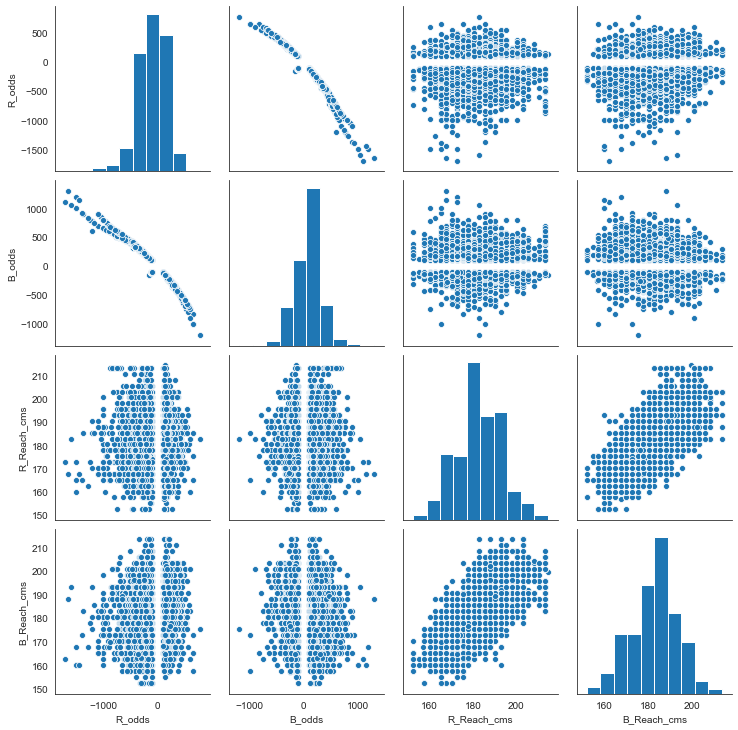

In [16]:
sns.set_style("white")
sns.pairplot(ufc_cut[['R_odds', 'B_odds', 'R_Reach_cms', 'B_Reach_cms']])

From the pairplot above you can see that "....."

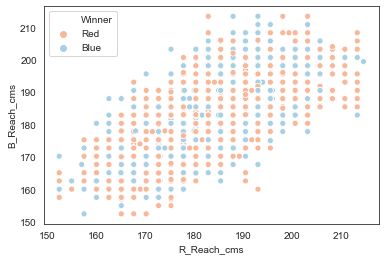

In [29]:
sns.scatterplot(x = "R_Reach_cms", y = "B_Reach_cms", data = ufc_cut, hue = "Winner",  palette="RdBu")

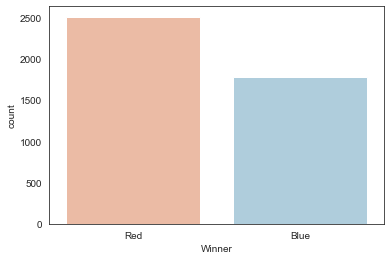

In [28]:
sns.countplot('Winner', data = ufc_cut,
              palette="RdBu")

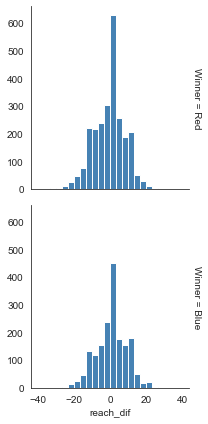

In [24]:
g = sns.FacetGrid(ufc_cut, row="Winner", margin_titles=True)
bins = np.linspace(start = -40, stop = 40, num = 25)
g.map(plt.hist, "reach_dif", color="steelblue", bins=bins)

# Modelling
We are implementing both Logistic Regression and Random Forest models to make a predictions on the UFC data set.

## Model Selection

#### Logistic Regression
Logistic regression is commonly used machine learning algorithm because it's highly interpretable, doesn't require too much computational power and doesn't need its input features to be scaled. Another advantage is that logistic regression is a classification model which outputs probabilities. This is an advantage because you can compare the outputs of two instances and determine which one is predicted to be closer to your target class. One thing to look out for when implementing logistic regression is that it cannot solve non-linear problems.

#### Random Forest
Random forest is a supervised learning algorithm that randomly creates and merges multiple decision trees into one “forest.” The goal is not to rely on a single learning model, but rather a collection of decision models to improve accuracy. The primary difference between this approach and the standard decision tree algorithms is that the root nodes feature splitting nodes are generated randomly.

In [9]:
# Create Classifiers
lr = LogisticRegression()

In [10]:
# Our 2 X columns 
ufc_cut_feat = ufc_cut[['R_odds', 'age_dif']]

# Our Y column
ufc_cut_targ = ufc_cut['Winner']

In [11]:
# Creating Training and Test set
seed = 50  # so that the result is reproducible
x_train, x_test, y_train, y_test = train_test_split(ufc_cut_feat, ufc_cut_targ , test_size = 0.2, random_state = seed)

In [12]:
# Fitting our Logistic Regression Model
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# Make predictions on test data
predictions = lr.predict(x_test)

In [14]:
# Use score method to get accuracy of model
score = lr.score(x_test, y_test)
print(score)

0.6623981373690337


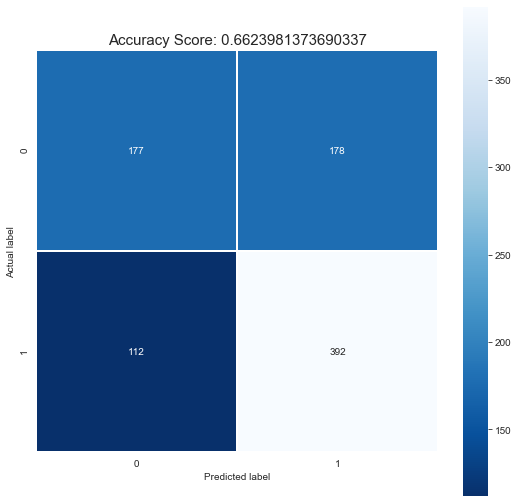

In [15]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Model Results
The three accuracy metrics we will use for this binary classification problem are Accuracy, Sensitivity and Specificity.

### 1.) Accuracy (all correct / all)
###### Logistic Regression
177 + 392 = 569
177 + 392 + 178 + 112 = 869
569 / 869 = 63.79%

###### Random Forest


### 2.) Sensitivity (true positives / all actual positives)
###### Logistic Regression
177 / 177 + 112 = 61.25%

###### Random Forest


### 3.) Specificity (true negatives / all actual negatives)
###### Logistic Regression
392 / (392 + 178) = 68.77%

###### Random Forest




# Results Discussion

In regards to Accuracy you can see that " " performed better. While " " performed better in regards to Sensitivity and " " performed better in Specificity. Overall, we recommend the " " model for this predicting who will win a UFC fight.
